[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ykitaguchi77/Eyelid_segmentation_inference/blob/main/inference_SegFormer_amodal.ipynb)

# SegFormer-B0 Amodal セグメンテーション推論

SegFormer-B0モデルを使用した眼領域のAmodal（重なりを許容する）セグメンテーション推論

## パイプライン構成
1. **Stage 1**: YOLO検出モデルで顔画像から両眼を検出 (Right_eye, Left_eye)
2. **Stage 2**: 検出したBBoxからROI（関心領域）を512x512で切り出し
3. **Stage 3**: SegFormer-B0でROI画像をセグメンテーション

## 出力マスク（3チャンネル、Multi-label）
| チャンネル | 名前 | 説明 | 表示色 |
|-----------|------|------|--------|
| 0 | eyelid | 眼瞼（まぶた）全体 | 赤 |
| 1 | iris | 虹彩（完全な楕円） | 緑 |
| 2 | pupil | 瞳孔（完全な楕円） | 青 |

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# ===== Cell 1: ライブラリのインポート =====
# 必要なライブラリを読み込みます

!pip install ultralytics

from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from ultralytics import YOLO  # YOLOv11検出モデル用
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor  # SegFormerモデル用

# PyTorchとGPUの情報を表示
print(f"PyTorch バージョン: {torch.__version__}")
print(f"CUDA (GPU) 利用可能: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU名: {torch.cuda.get_device_name(0)}")

PyTorch バージョン: 2.9.0+cpu
CUDA (GPU) 利用可能: False


In [37]:
# ===== Cell 2: 設定およびモデルファイルのダウンロード =====
# モデルパスや推論パラメータを設定し、必要なモデルファイルをダウンロードします

# プロジェクトのルートディレクトリ
PROJECT_ROOT = Path(".").resolve()

# モデルファイルのダウンロード
print("モデルファイルをダウンロード中...")
!wget -nc https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/YOLO11l-detect.pt -P {PROJECT_ROOT}
!wget -nc https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/segformer_b0_amodal_best.pth -P {PROJECT_ROOT}
!wget -nc https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/sample_image.png -P {PROJECT_ROOT}
!wget -nc https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/sample_image_2.png -P {PROJECT_ROOT}
print("ダウンロード完了!")

# Stage 1: YOLO検出モデル（両眼の位置を検出）
DETECT_MODEL_PATH = PROJECT_ROOT / "YOLO11l-detect.pt"

# Stage 2: SegFormer Amodalモデル（眼領域をセグメンテーション）
SEGFORMER_MODEL_NAME = "nvidia/segformer-b0-finetuned-ade-512-512"  # ベースモデル
SEGFORMER_MODEL_PATH = PROJECT_ROOT / "segformer_b0_amodal_best.pth"

# 推論パラメータ
IMAGE_SIZE = 512          # ROIのサイズ（512x512ピクセル）
NUM_CHANNELS = 3          # 出力チャンネル数（eyelid, iris, pupil）
THRESHOLD = 0.5           # マスクの2値化閾値（0.5以上を検出領域とする）
EXPANSION_RATIO = 0.25    # ROI抽出時の拡張率（25%のマージンを追加）

# デバイス設定（GPUがあればGPU、なければCPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# サンプル画像のパス
SAMPLE_IMAGES = [
   "/content/drive/MyDrive/AI_laboratory_course/face.jpg"
]

print("=" * 50)
print("設定情報")
print("=" * 50)
print(f"検出モデル: {DETECT_MODEL_PATH}")
print(f"SegFormerモデル: {SEGFORMER_MODEL_PATH}")
print(f"デバイス: {device}")
print(f"ROIサイズ: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"拡張率: {EXPANSION_RATIO} ({int(EXPANSION_RATIO*100)}%)")
print(f"閾値: {THRESHOLD}")

モデルファイルをダウンロード中...
--2026-01-19 07:53:46--  https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/YOLO11l-detect.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-19 07:53:46 ERROR 404: Not Found.

--2026-01-19 07:53:46--  https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/segformer_b0_amodal_best.pth
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-19 07:53:46 ERROR 404: Not Found.

--2026-01-19 07:53:47--  https://github.com/ykitaguchi77/Eyelid_segmentation_inference/raw/main/sample_image.png
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-19 07:53:47 E

In [28]:
# ===== Cell 3: モデルの読み込み =====
# Stage1（検出）とStage2（セグメンテーション）のモデルを読み込みます

from pathlib import Path

SEGFORMER_MODEL_PATH = Path("/content/drive/MyDrive/AI_laboratory_course/眼瞼/segformer_b0_amodal_best.pth")
print("=" * 50)
print("モデルの読み込み")
print("=" * 50)

# ----- Stage 1: YOLO検出モデル -----
print("\n[Stage 1] YOLO検出モデルを読み込み中...")
detect_model = YOLO(str(DETECT_MODEL_PATH))
print(f"  読み込み完了!")
print(f"  検出クラス: {detect_model.names}")

# ----- Stage 2: SegFormerモデル -----
print("\n[Stage 2] SegFormerモデルを読み込み中...")

def create_segformer_model(num_labels=3):
    """SegFormer-B0モデルを作成（3チャンネル出力）"""
    model = SegformerForSemanticSegmentation.from_pretrained(
        SEGFORMER_MODEL_NAME,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )
    return model

# モデルファイルの存在確認
if not SEGFORMER_MODEL_PATH.exists():
    raise FileNotFoundError(f"モデルが見つかりません: {SEGFORMER_MODEL_PATH}")

# モデルを作成し、学習済み重みを読み込み
seg_model = create_segformer_model(num_labels=NUM_CHANNELS).to(device)
checkpoint = torch.load(SEGFORMER_MODEL_PATH, map_location=device, weights_only=False)
seg_model.load_state_dict(checkpoint["model"])
seg_model.eval()  # 推論モードに設定

print(f"  読み込み完了!")
print(f"  学習エポック: {checkpoint['epoch']}")
print(f"  検証Dice: {checkpoint['val_dice']['mean']:.4f}")
print(f"    - Eyelid: {checkpoint['val_dice']['eyelid']:.4f}")
print(f"    - Iris: {checkpoint['val_dice']['iris']:.4f}")
print(f"    - Pupil: {checkpoint['val_dice']['pupil']:.4f}")

モデルの読み込み

[Stage 1] YOLO検出モデルを読み込み中...
  読み込み完了!
  検出クラス: {0: 'Right_eye', 1: 'Left_eye'}

[Stage 2] SegFormerモデルを読み込み中...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  読み込み完了!
  学習エポック: 87
  検証Dice: 0.9442
    - Eyelid: 0.9586
    - Iris: 0.9552
    - Pupil: 0.9188


入力画像: /content/drive/MyDrive/AI_laboratory_course/face.jpg
画像サイズ: 1024x1024 ピクセル


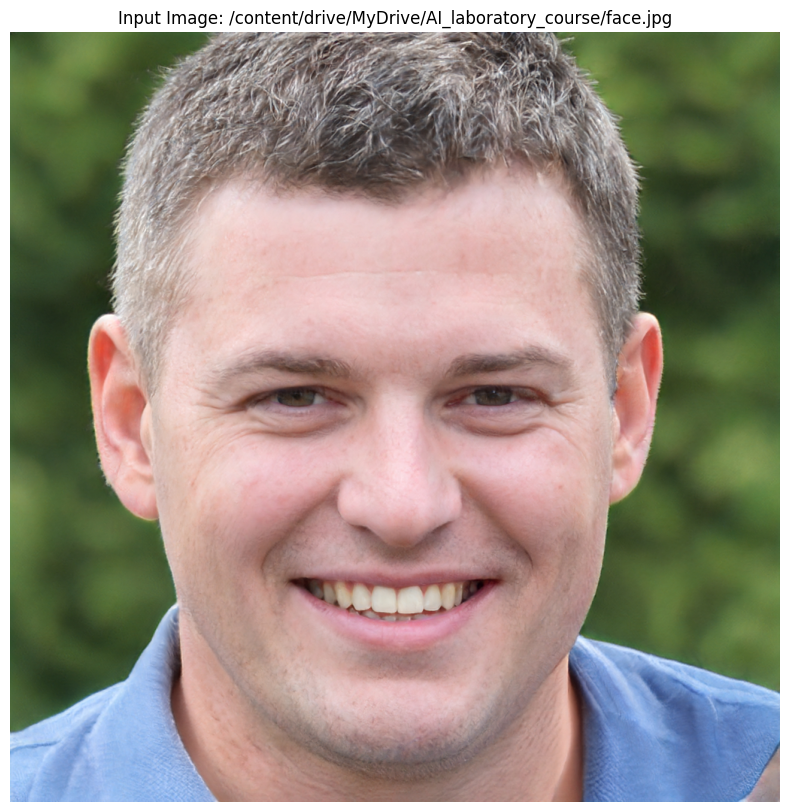

In [38]:
# ===== Cell 4: 入力画像の読み込みと表示 =====
# 推論に使用する画像を読み込み、表示します

# 使用する画像（最初のサンプル画像）
IMAGE_PATH = SAMPLE_IMAGES[0]

# 画像を読み込み
img = cv2.imread(str(IMAGE_PATH))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGRからRGBに変換（表示用）

print(f"入力画像: {IMAGE_PATH}")
print(f"画像サイズ: {img.shape[1]}x{img.shape[0]} ピクセル")

# 元画像を表示
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.title(f"Input Image: {IMAGE_PATH}")
plt.axis('off')
plt.show()

Stage 1: 眼の検出

検出数: 2 眼

[1] Left_eye
    信頼度: 0.894 (89.4%)
    BBox: x1=579, y1=472, x2=688, y2=499

[2] Right_eye
    信頼度: 0.889 (88.9%)
    BBox: x1=335, y1=473, x2=448, y2=499


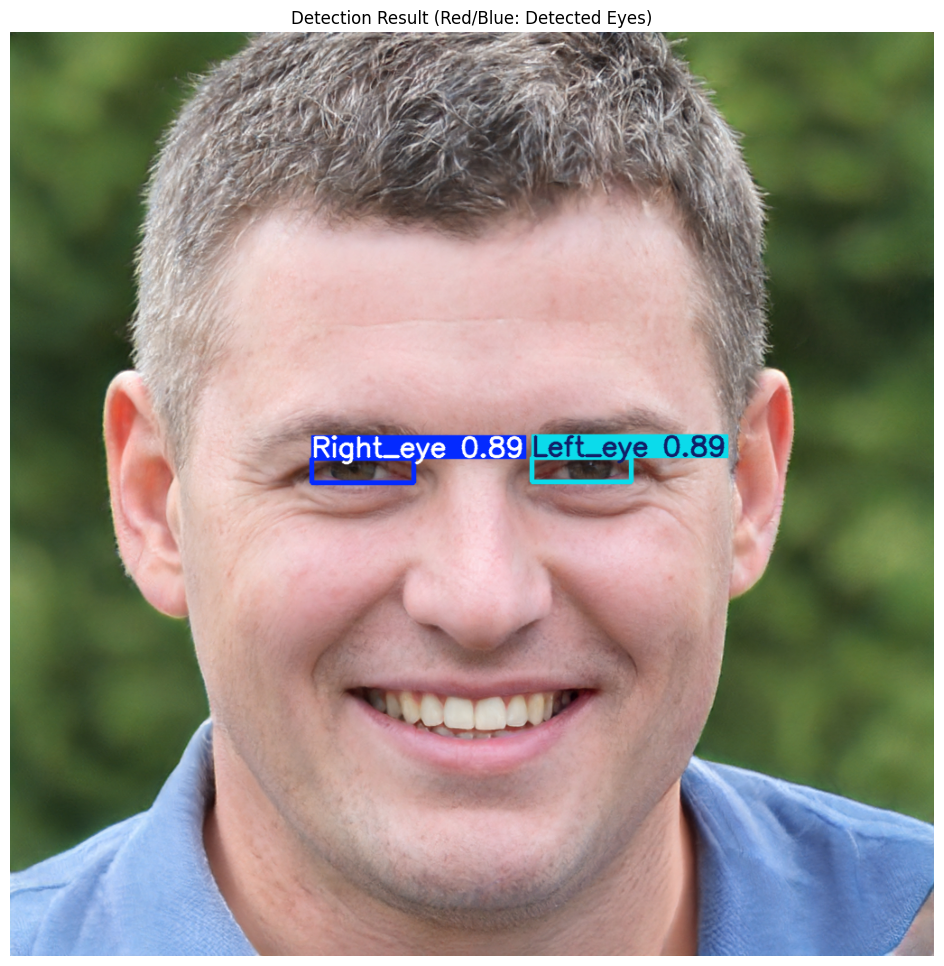

In [39]:
# ===== Cell 5: Stage 1 - 眼の検出 =====
# YOLOモデルで顔画像から両眼の位置を検出します

print("=" * 50)
print("Stage 1: 眼の検出")
print("=" * 50)

# 検出を実行
detect_results = detect_model.predict(
    source=img,
    conf=0.25,   # 信頼度閾値（25%以上を検出）
    iou=0.45,    # NMS（非最大値抑制）のIoU閾値
    verbose=False
)[0]

print(f"\n検出数: {len(detect_results.boxes)} 眼")

# 検出結果の詳細を表示
for i, box in enumerate(detect_results.boxes):
    cls_id = int(box.cls[0])
    cls_name = detect_model.names[cls_id]
    conf = float(box.conf[0])
    xyxy = box.xyxy[0].cpu().numpy()

    print(f"\n[{i+1}] {cls_name}")
    print(f"    信頼度: {conf:.3f} ({conf*100:.1f}%)")
    print(f"    BBox: x1={xyxy[0]:.0f}, y1={xyxy[1]:.0f}, x2={xyxy[2]:.0f}, y2={xyxy[3]:.0f}")

# 検出結果を可視化
result_img = detect_results.plot()
result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(result_img_rgb)
plt.title("Detection Result (Red/Blue: Detected Eyes)")
plt.axis('off')
plt.show()

In [40]:
# ===== Cell 6: ROI抽出関数の定義 =====
# 検出したBBoxから眼領域（ROI）を切り出す関数を定義します

def extract_roi(image, bbox, roi_size=512, expansion_ratio=0.25):
    """
    検出したBBoxからROI（関心領域）を抽出

    処理の流れ:
    1. BBoxの中心を計算
    2. 正方形にするため、長辺に合わせる
    3. マージン（expansion_ratio）を追加
    4. 画像境界をはみ出す場合は黒でパディング
    5. 指定サイズ（roi_size）にリサイズ

    Args:
        image: 入力画像（BGR）
        bbox: バウンディングボックス [x1, y1, x2, y2]
        roi_size: 出力ROIのサイズ（デフォルト512x512）
        expansion_ratio: 拡張率（デフォルト25%）

    Returns:
        roi: 抽出したROI画像
        transform_info: 座標変換用の情報（元画像への逆変換に使用）
    """
    h, w = image.shape[:2]
    x1, y1, x2, y2 = bbox

    # BBoxの中心座標
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    # 正方形化 + マージン追加後の辺の長さ
    side = max(x2 - x1, y2 - y1) * (1 + 2 * expansion_ratio)

    # 拡張後の座標
    nx1, ny1 = int(cx - side / 2), int(cy - side / 2)
    nx2, ny2 = int(cx + side / 2), int(cy + side / 2)

    # 画像境界をはみ出す場合のパディング量
    pad_top = max(0, -ny1)
    pad_bottom = max(0, ny2 - h)
    pad_left = max(0, -nx1)
    pad_right = max(0, nx2 - w)

    # 画像範囲内のみを切り出し
    roi = image[max(0, ny1):min(h, ny2), max(0, nx1):min(w, nx2)].copy()

    # はみ出した部分は黒（0, 0, 0）でパディング
    if pad_top or pad_bottom or pad_left or pad_right:
        roi = cv2.copyMakeBorder(roi, pad_top, pad_bottom, pad_left, pad_right,
                                  cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # 座標変換情報を保存（元画像への逆変換に使用）
    transform_info = {
        'original_bbox': bbox,
        'expanded_bbox': [nx1, ny1, nx2, ny2],
        'padding': [pad_top, pad_bottom, pad_left, pad_right],
        'scale': roi_size / side,
        'center': (cx, cy),
        'side': side
    }

    # 指定サイズにリサイズ
    return cv2.resize(roi, (roi_size, roi_size)), transform_info


print("ROI抽出関数を定義しました")

ROI抽出関数を定義しました


Stage 2: ROI抽出

Left_eye: ROI抽出完了 (512x512)

Right_eye: ROI抽出完了 (512x512)


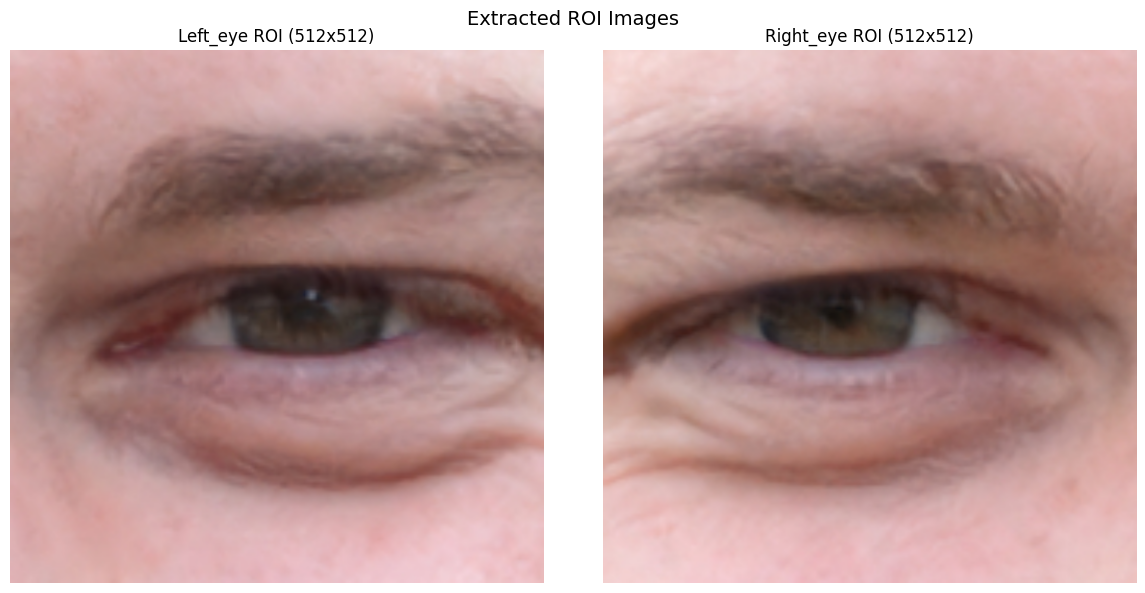

In [41]:
# ===== Cell 7: Stage 2 - ROIの抽出と表示 =====
# 検出したBBoxからROIを切り出し、表示します

print("=" * 50)
print("Stage 2: ROI抽出")
print("=" * 50)

# 各眼のROIを抽出
rois = []         # ROI画像を格納
eye_names = []    # 眼の名前（Right_eye / Left_eye）
bboxes = []       # 元のBBox
transform_infos = []  # 座標変換情報

for box in detect_results.boxes:
    cls_name = detect_model.names[int(box.cls[0])]
    bbox = box.xyxy[0].cpu().numpy()

    # ROIを抽出
    roi, transform_info = extract_roi(img, bbox, roi_size=IMAGE_SIZE, expansion_ratio=EXPANSION_RATIO)

    rois.append(roi)
    eye_names.append(cls_name)
    bboxes.append(bbox)
    transform_infos.append(transform_info)

    print(f"\n{cls_name}: ROI抽出完了 ({IMAGE_SIZE}x{IMAGE_SIZE})")

# 抽出したROIを表示
fig, axes = plt.subplots(1, len(rois), figsize=(6 * len(rois), 6))
if len(rois) == 1:
    axes = [axes]

for ax, roi, name in zip(axes, rois, eye_names):
    ax.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{name} ROI ({IMAGE_SIZE}x{IMAGE_SIZE})")
    ax.axis('off')

plt.suptitle("Extracted ROI Images", fontsize=14)
plt.tight_layout()
plt.show()

In [42]:
# ===== Cell 8: SegFormer推論関数の定義 =====
# SegFormerモデルでROI画像をセグメンテーションする関数を定義します

def predict_amodal(model, roi_image, device, image_size=512, threshold=0.5):
    """
    SegFormer Amodalモデルで推論を実行

    Amodal（アモーダル）セグメンテーションとは:
    - 各マスク（eyelid, iris, pupil）が独立して予測される
    - マスク同士の重なりが許容される（pupil ⊂ iris ⊂ eyelid）
    - 瞼で隠れた部分も含めた「完全な」領域を予測

    Args:
        model: SegFormerモデル
        roi_image: ROI画像（RGBのnumpy配列）
        device: 推論デバイス（cuda/cpu）
        image_size: モデルの入力サイズ
        threshold: 2値化閾値

    Returns:
        masks: 各チャンネルの2値マスク {'eyelid', 'iris', 'pupil'}
        probs: 各チャンネルの確率マップ
    """
    # RGBに変換（必要な場合）
    if roi_image.shape[-1] == 3 and len(roi_image.shape) == 3:
        img_rgb = roi_image
    else:
        img_rgb = cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB)

    # SegFormer用の前処理（正規化など）
    processor = SegformerImageProcessor.from_pretrained(
        SEGFORMER_MODEL_NAME, do_resize=False, do_rescale=True, do_normalize=True
    )
    inputs = processor(images=img_rgb, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    # 推論を実行
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # SegFormerの出力は入力より小さいため、元のサイズに拡大
        if logits.shape[-2:] != (image_size, image_size):
            logits = F.interpolate(
                logits, size=(image_size, image_size),
                mode='bilinear', align_corners=False
            )

        # Sigmoid関数で確率に変換（Multi-labelなのでSoftmaxではなくSigmoid）
        probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()

    # マスクを作成（閾値以上を検出領域とする）
    channel_names = ['eyelid', 'iris', 'pupil']
    masks = {}
    probs_dict = {}

    for c, name in enumerate(channel_names):
        probs_dict[name] = probs[c]
        masks[name] = ((probs[c] > threshold) * 255).astype(np.uint8)

    return masks, probs_dict


print("SegFormer推論関数を定義しました")

SegFormer推論関数を定義しました


In [43]:
# ===== Cell 9: Stage 3 - セグメンテーション推論 =====
# 各ROIに対してSegFormerでセグメンテーション推論を実行します

print("=" * 50)
print("Stage 3: セグメンテーション推論")
print("=" * 50)

# 各ROIに対してセグメンテーション推論を実行
seg_results = []  # セグメンテーション結果を格納

for roi, name in zip(rois, eye_names):
    # ROIをRGBに変換
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    # 推論を実行
    masks, probs = predict_amodal(seg_model, roi_rgb, device, IMAGE_SIZE, THRESHOLD)

    seg_results.append({
        'eye_name': name,
        'roi_rgb': roi_rgb,
        'masks': masks,
        'probs': probs
    })

    # 結果を表示
    total_pixels = IMAGE_SIZE * IMAGE_SIZE
    print(f"\n{name}: セグメンテーション完了")
    print(f"  Eyelid: {(masks['eyelid'] > 0).sum():>6} pixels ({100 * (masks['eyelid'] > 0).sum() / total_pixels:.1f}%)")
    print(f"  Iris:   {(masks['iris'] > 0).sum():>6} pixels ({100 * (masks['iris'] > 0).sum() / total_pixels:.1f}%)")
    print(f"  Pupil:  {(masks['pupil'] > 0).sum():>6} pixels ({100 * (masks['pupil'] > 0).sum() / total_pixels:.1f}%)")

print("\n全てのROIの推論が完了しました")

Stage 3: セグメンテーション推論


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)



Left_eye: セグメンテーション完了
  Eyelid:  18370 pixels (7.0%)
  Iris:    22445 pixels (8.6%)
  Pupil:    1982 pixels (0.8%)

Right_eye: セグメンテーション完了
  Eyelid:  17174 pixels (6.6%)
  Iris:    25643 pixels (9.8%)
  Pupil:    2010 pixels (0.8%)

全てのROIの推論が完了しました


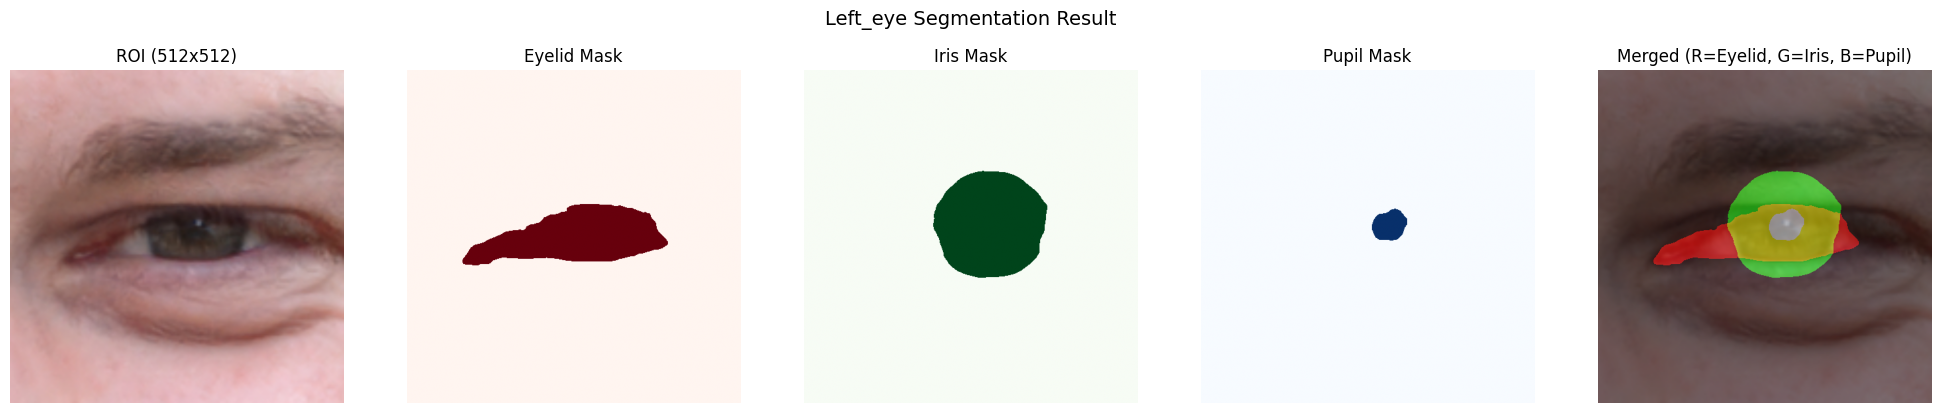

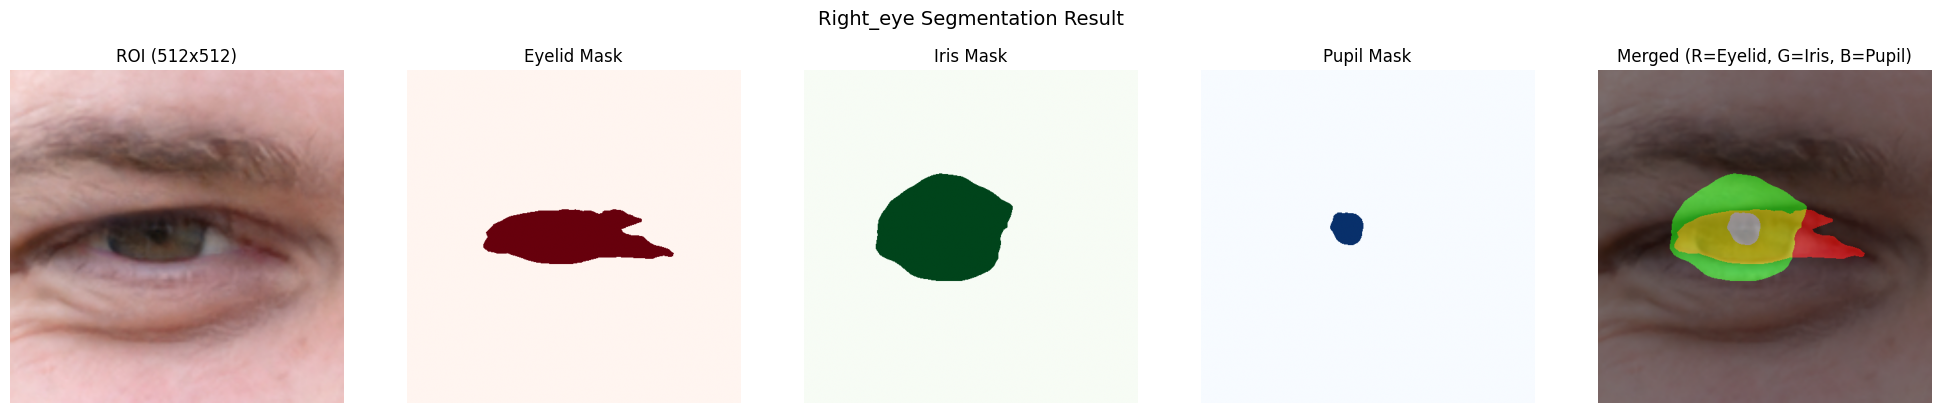

In [44]:
# ===== Cell 10: セグメンテーション結果の可視化 =====
# 各眼のセグメンテーション結果を表示します
# 表示内容: ROI | Eyelid Mask | Iris Mask | Pupil Mask | Merged

def create_merged_overlay(img_rgb, eyelid_mask, iris_mask, pupil_mask, alpha=0.5):
    """
    3つのマスクを重ねたオーバーレイ画像を作成
    色: Eyelid=赤, Iris=緑, Pupil=青
    """
    h, w = img_rgb.shape[:2]
    color_mask = np.zeros((h, w, 3), dtype=np.float32)

    # 各マスクに色を割り当て
    color_mask[eyelid_mask > 0, 0] = 255  # 赤: Eyelid
    color_mask[iris_mask > 0, 1] = 255    # 緑: Iris
    color_mask[pupil_mask > 0, 2] = 255   # 青: Pupil

    # 元画像とブレンド
    overlay = img_rgb.astype(np.float32) * (1 - alpha) + color_mask * alpha
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    return overlay


# 各眼の結果を表示
for res in seg_results:
    roi_rgb = res['roi_rgb']
    masks = res['masks']
    eye_name = res['eye_name']

    # マージ画像を作成
    merged = create_merged_overlay(roi_rgb, masks['eyelid'], masks['iris'], masks['pupil'])

    # 5列で表示: ROI | Eyelid | Iris | Pupil | Merged
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # ROI（元画像）
    axes[0].imshow(roi_rgb)
    axes[0].set_title("ROI (512x512)")
    axes[0].axis("off")

    # Eyelidマスク（赤系カラーマップ）
    axes[1].imshow(masks['eyelid'], cmap='Reds', vmin=0, vmax=255)
    axes[1].set_title("Eyelid Mask")
    axes[1].axis("off")

    # Irisマスク（緑系カラーマップ）
    axes[2].imshow(masks['iris'], cmap='Greens', vmin=0, vmax=255)
    axes[2].set_title("Iris Mask")
    axes[2].axis("off")

    # Pupilマスク（青系カラーマップ）
    axes[3].imshow(masks['pupil'], cmap='Blues', vmin=0, vmax=255)
    axes[3].set_title("Pupil Mask")
    axes[3].axis("off")

    # マージ画像（3マスクを重畳表示）
    axes[4].imshow(merged)
    axes[4].set_title("Merged (R=Eyelid, G=Iris, B=Pupil)")
    axes[4].axis("off")

    fig.suptitle(f"{eye_name} Segmentation Result", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [46]:
# ===== Cell 11: 結果の保存 =====
# セグメンテーション結果をファイルに保存します

def save_results(image_path, seg_results, output_dir=None):
    """
    セグメンテーション結果をファイルに保存

    保存されるファイル（各眼ごと）:
    - {画像名}_{眼名}_roi.png        : 切り出したROI画像
    - {画像名}_{眼名}_eyelid_mask.png : Eyelidマスク
    - {画像名}_{眼名}_iris_mask.png   : Irisマスク
    - {画像名}_{眼名}_pupil_mask.png  : Pupilマスク
    - {画像名}_{眼名}_merged.png      : マージ画像
    """
    image_path = Path(image_path)
    if output_dir is None:
        output_dir = image_path.parent
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    stem = image_path.stem  # 拡張子を除いたファイル名

    for res in seg_results:
        eye_name = res['eye_name']
        roi_rgb = res['roi_rgb']
        masks = res['masks']
        merged = create_merged_overlay(roi_rgb, masks['eyelid'], masks['iris'], masks['pupil'])

        # ROI画像を保存（RGBからBGRに変換）
        cv2.imwrite(str(output_dir / f"{stem}_{eye_name}_roi.png"),
                    cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR))

        # 各マスクを保存
        cv2.imwrite(str(output_dir / f"{stem}_{eye_name}_eyelid_mask.png"), masks['eyelid'])
        cv2.imwrite(str(output_dir / f"{stem}_{eye_name}_iris_mask.png"), masks['iris'])
        cv2.imwrite(str(output_dir / f"{stem}_{eye_name}_pupil_mask.png"), masks['pupil'])

        # マージ画像を保存
        cv2.imwrite(str(output_dir / f"{stem}_{eye_name}_merged.png"),
                    cv2.cvtColor(merged, cv2.COLOR_RGB2BGR))

        print(f"保存完了: {stem}_{eye_name}_*.png")


# 結果を保存（コメントを外して実行）
# save_results(IMAGE_PATH, seg_results)

print("保存関数を定義しました")
print("使い方: save_results(IMAGE_PATH, seg_results)")

保存関数を定義しました
使い方: save_results(IMAGE_PATH, seg_results)


In [47]:
# ===== Cell 12: 別の画像で推論（オプション） =====
# 他のサンプル画像がある場合、ここで推論を実行できます

# ========================================
# ここに処理したい画像のパスを指定してください
# ========================================
TARGET_IMAGE_PATH = PROJECT_ROOT / "sample_image_2.png"
# TARGET_IMAGE_PATH = Path(r"C:\path\to\your\image.png")  # 任意の画像パス
# ========================================


def run_full_pipeline(image_path, detect_model, seg_model, device, visualize=True):
    """
    画像パスを指定して、検出からセグメンテーションまでの全パイプラインを実行

    Args:
        image_path: 入力画像のパス
        detect_model: YOLO検出モデル
        seg_model: SegFormerセグメンテーションモデル
        device: 推論デバイス
        visualize: 結果を表示するかどうか

    Returns:
        seg_results: セグメンテーション結果のリスト
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"画像が見つかりません: {image_path}")

    print(f"\n{'='*50}")
    print(f"処理中: {image_path.name}")
    print(f"{'='*50}")

    # 画像を読み込み
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Stage 1: 検出
    detect_results = detect_model.predict(source=img, conf=0.25, iou=0.45, verbose=False)[0]
    print(f"検出数: {len(detect_results.boxes)} 眼")

    if len(detect_results.boxes) == 0:
        print("眼が検出されませんでした")
        return []

    # Stage 2 & 3: ROI抽出とセグメンテーション
    seg_results = []
    for box in detect_results.boxes:
        cls_name = detect_model.names[int(box.cls[0])]
        bbox = box.xyxy[0].cpu().numpy()

        roi, _ = extract_roi(img, bbox, IMAGE_SIZE, EXPANSION_RATIO)
        roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        masks, probs = predict_amodal(seg_model, roi_rgb, device, IMAGE_SIZE, THRESHOLD)

        seg_results.append({
            'eye_name': cls_name,
            'roi_rgb': roi_rgb,
            'masks': masks,
            'probs': probs
        })
        print(f"  {cls_name}: 推論完了")

    # 結果を表示
    if visualize:
        for res in seg_results:
            roi_rgb = res['roi_rgb']
            masks = res['masks']
            merged = create_merged_overlay(roi_rgb, masks['eyelid'], masks['iris'], masks['pupil'])

            fig, axes = plt.subplots(1, 5, figsize=(20, 4))
            axes[0].imshow(roi_rgb); axes[0].set_title("ROI"); axes[0].axis('off')
            axes[1].imshow(masks['eyelid'], cmap='Reds', vmin=0, vmax=255); axes[1].set_title("Eyelid"); axes[1].axis('off')
            axes[2].imshow(masks['iris'], cmap='Greens', vmin=0, vmax=255); axes[2].set_title("Iris"); axes[2].axis('off')
            axes[3].imshow(masks['pupil'], cmap='Blues', vmin=0, vmax=255); axes[3].set_title("Pupil"); axes[3].axis('off')
            axes[4].imshow(merged); axes[4].set_title("Merged"); axes[4].axis('off')
            fig.suptitle(f"{res['eye_name']} - {image_path.name}", fontsize=14)
            plt.tight_layout()
            plt.show()

    return seg_results


# 指定した画像で推論を実行
if TARGET_IMAGE_PATH.exists():
    print(f"指定画像: {TARGET_IMAGE_PATH}")
    results_additional = run_full_pipeline(TARGET_IMAGE_PATH, detect_model, seg_model, device)
else:
    print(f"画像が見つかりません: {TARGET_IMAGE_PATH}")
    print("TARGET_IMAGE_PATH に有効なパスを指定してください")

画像が見つかりません: /content/sample_image_2.png
TARGET_IMAGE_PATH に有効なパスを指定してください


## まとめ

このノートブックでは、SegFormer-B0 Amodalモデルを使用した眼領域のセグメンテーションを行いました。

### パイプライン
1. **Stage 1**: YOLOで顔画像から両眼を検出 (Right_eye, Left_eye)
2. **Stage 2**: 検出したBBoxからROI (512x512) を切り出し
3. **Stage 3**: SegFormer-B0でROI画像をセグメンテーション

### 出力マスク
| チャンネル | 名前 | 説明 | 色 |
|-----------|------|------|----|
| 0 | eyelid | 眼瞼全体（瞼で隠れた部分含む） | 赤 |
| 1 | iris | 虹彩（完全な楕円） | 緑 |
| 2 | pupil | 瞳孔（完全な楕円） | 青 |

### 主な関数
- `extract_roi()`: BBoxからROIを切り出し
- `predict_amodal()`: SegFormerでセグメンテーション推論
- `create_merged_overlay()`: 3マスクを重畳表示
- `save_results()`: 結果をファイルに保存
- `run_full_pipeline()`: 検出からセグメンテーションまで一括実行